In [53]:
# Useful resources
# https://medium.com/analytics-vidhya/testing-multiple-machine-learning-models-at-once-without-getting-a-headache-5aefb0e7df03
# Potentially look into ensemble models

In [54]:
# In prep
import pandas as pd
import utm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

seed = 38 # Seed for train/val split

In [55]:
#Function to convert geographic to projected coordinates
def from_latlon(lat, lon):
    easting, northing, zone_num, zone_letter = utm.from_latlon(lat, lon)
    return easting, northing, zone_num, zone_letter

In [56]:
def preprocess_sim_data(sim_data, data_type, freq, tower_locs):
    # Get data
    sim_dat_filt = sim_data[sim_data['Data_type'].isin(data_type)]

    # make column with the datetime to nearest 'freq' value (e.g. 5min)
    sim_dat_filt = sim_dat_filt.assign(DateTime = sim_dat_filt['DateAndTime'].dt.floor(freq=freq))

    # group by datetime, tag, tower and antenna, compute mean power, pivot to antennas
    sim_dat_filt = (
        sim_dat_filt.groupby(['DateTime', 'TowerID', 'TagID', 'Antenna', 'POINT_X', 'POINT_Y'])['Power']
        .mean()
        .reset_index()
        .pivot_table(index=['DateTime', 'TowerID', 'TagID', 'POINT_X', 'POINT_Y'], columns='Antenna', values='Power')
        .reset_index()
        .rename(columns={1: 'ant1', 2: 'ant2', 3: 'ant3', 4: 'ant4'})
        .fillna(value=0) # Need to check the impact of this
    )
    # Calculate easting and northing from lat long
    sim_dat_filt['easting'], sim_dat_filt['northing'], sim_dat_filt['zone_num'], sim_dat_filt['zone_letter'] = from_latlon(sim_dat_filt['POINT_Y'].values, sim_dat_filt['POINT_X'].values)

    # Create a dictionary of the coordinates of the towers
    offset_dict = tower_locs.set_index('TowerID').to_dict()
    point_x = offset_dict['POINT_X']
    point_y = offset_dict['POINT_Y']

    # Standardise the coordinates so that the tower location == 0 on both the x and y axes.
    sim_dat_filt['xOffset'] = sim_dat_filt['easting'] - sim_dat_filt['TowerID'].map(point_x).fillna(0)
    sim_dat_filt['yOffset'] = sim_dat_filt['northing'] - sim_dat_filt['TowerID'].map(point_y).fillna(0)

    return sim_dat_filt

In [57]:
# Get simulation data
sim_data_path = 'H:\My Drive\Colab Notebooks\RadioTelemetry\Simul_data\Processed_RTdat_w_LatLong_append\RTdat_sim_train_20230212.xlsx'
sim_data = pd.read_excel(sim_data_path)
sim_data['DateAndTime'] = pd.to_datetime(sim_data['DateAndTime'])

# Get tower locations
radio_tower_xy_path = 'H:\My Drive\Colab Notebooks\RadioTelemetry\Tower_data\RTEastNorth.xlsx'
tower_locs = pd.read_excel(radio_tower_xy_path)


In [58]:
# Initial pass over the data using lazy predict to identify possible options
# import lazypredict
# from lazypredict.Supervised import LazyRegressor
# reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
# models, predictions = reg.fit(X_train, X_test, y_train, y_test)
# print(models)

In [59]:
# Drilling into top performing models for paramater optimisation
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor

# Create a list of test dictionaries
KNeighborsRegressor_params = [{"n_neighbors":3}, {"n_neighbors":5}, {"n_neighbors":7}]
AdaBoostRegressor_params = [{"n_estimators":25}, {"n_estimators":50}, {"n_estimators":75}]

# Create classes for the models
modelclasses = [
    ["K neighbours regressor", KNeighborsRegressor, KNeighborsRegressor_params],
    ["Ada boost regressor", AdaBoostRegressor, AdaBoostRegressor_params]
]

In [60]:
# Pre-processing parameters to test
# Variable parameters
data_type = ['Simulation'] # Simulation or Live BTF, or could do both
frequencies = ['1min', '5min']
cv = [] #To be updated

# Fixed parameters
dimensions = ['xOffset', 'yOffset']
predictors = ['ant1', 'ant2', 'ant3', 'ant4']
responses = ['xOffset', 'yOffset']
scoring = 'neg_mean_absolute_error'

trained_models = []
for dimension in dimensions:
    for freq in frequencies:
        sim_data_preproc = preprocess_sim_data(sim_data, data_type, freq, tower_locs)
        X_train = sim_data_preproc[predictors]
        y_train = sim_data_preproc[dimension] # Will need to adjust this to iterate over x and y xOffset

        # X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=seed)

        for modelname, Model, params_list in modelclasses:
            for params in params_list:
                model = Model(**params)
                scores = cross_val_score(model, X_train, y_train, cv=3, scoring=scoring)
                score = np.mean(scores)
                model.fit(X_train, y_train)
                trained_models.append((dimension, modelname, model, params, freq, score))

In [61]:
best_models = []
for dimension in dimensions:
    filtered = [x for x in trained_models if x[0] == dimension]
    filtered.sort(key=lambda x:x[-1], reverse=True)
    best_model = filtered[0]
    best_models.append(best_model)
    print(f"\nThe best performing model for {dimension} was {best_model}\n\nAll model results as follows:")

    for dimension, modelname, model, params, freq, score in filtered:
        print(dimension, modelname, params, freq, score)        


The best performing model for xOffset was ('xOffset', 'K neighbours regressor', KNeighborsRegressor(n_neighbors=7), {'n_neighbors': 7}, '5min', -330.47414811013624)

All model results as follows:
xOffset K neighbours regressor {'n_neighbors': 7} 5min -330.47414811013624
xOffset Ada boost regressor {'n_estimators': 75} 1min -336.2508123787026
xOffset K neighbours regressor {'n_neighbors': 5} 5min -336.9463595525065
xOffset Ada boost regressor {'n_estimators': 50} 1min -341.019378879073
xOffset Ada boost regressor {'n_estimators': 75} 5min -341.1759593044805
xOffset Ada boost regressor {'n_estimators': 50} 5min -344.86357807730684
xOffset Ada boost regressor {'n_estimators': 25} 1min -346.4041621440986
xOffset Ada boost regressor {'n_estimators': 25} 5min -352.869656052379
xOffset K neighbours regressor {'n_neighbors': 3} 5min -358.0420858763479
xOffset K neighbours regressor {'n_neighbors': 7} 1min -358.6632137873644
xOffset K neighbours regressor {'n_neighbors': 5} 1min -367.430197936

In [62]:
# Pre-process test data !!!!!!!!!!!change code to reflect test data
sim_data_preproc = preprocess_sim_data(sim_data, data_type, freq, tower_locs) #### Change this to Test data

# Isolate predictor variables from test data
X_test = sim_data_preproc[predictors]

for dimension in dimensions:
    best_model = [x for x in best_models if x[0] == dimension]
    model = best_model[0][2]
    freq = best_model[0][4]

    # Isolate response variable from test data
    y_test = sim_data_preproc[dimension]

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Save predictions to a new column in the test data pandas dataframe
    pred_column_name = f"{dimension}_pred"
    sim_data_preproc[pred_column_name] = y_pred

    # # Save frequency of predictions to the pandas dataframe !!!!!!!!!!Consider deleting, I don't think it's needed
    # freq_column_name = f"{dimension}_freq"
    # sim_data_preproc[freq_column_name] = freq

In [63]:
sim_data_preproc

Antenna,DateTime,TowerID,TagID,POINT_X,POINT_Y,ant1,ant2,ant3,ant4,easting,northing,zone_num,zone_letter,xOffset,yOffset,xOffset_pred,yOffset_pred
0,2021-03-19 07:50:00,RT01,70,146.255492,-21.919407,0.0,0.000000,0.0,84.000000,423106.337491,7.575907e+06,55,K,-232.393693,-11.475495,-497.401942,-32.265108
1,2021-03-19 07:50:00,RT04,70,146.255492,-21.919407,105.0,80.000000,0.0,0.000000,423106.337491,7.575907e+06,55,K,160.219630,233.088540,116.429167,294.862593
2,2021-03-19 07:55:00,RT01,70,146.255492,-21.919407,78.0,106.000000,34.0,0.000000,423106.337491,7.575907e+06,55,K,-232.393693,-11.475495,19.871090,4.234169
3,2021-03-19 07:55:00,RT02,70,146.255492,-21.919407,0.0,55.000000,0.0,0.000000,423106.337491,7.575907e+06,55,K,-746.125298,299.312629,-342.473875,59.422225
4,2021-03-19 07:55:00,RT03,70,146.255492,-21.919407,76.0,0.000000,0.0,0.000000,423106.337491,7.575907e+06,55,K,-282.582580,495.944163,-116.295105,349.078872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,2021-04-23 15:05:00,RT01,70,146.252698,-21.920308,0.0,78.500000,0.0,88.000000,422818.243652,7.575806e+06,55,K,-520.487532,-112.611280,-430.966631,-45.218327
512,2021-04-23 15:05:00,RT03,70,146.252698,-21.920308,66.5,0.000000,0.0,0.000000,422818.243652,7.575806e+06,55,K,-570.676419,394.808378,-196.334351,102.825429
513,2021-04-23 15:05:00,RT05,70,146.252698,-21.920308,68.0,0.000000,83.5,0.000000,422818.243652,7.575806e+06,55,K,-126.932490,-366.296196,-226.655585,-427.217776
514,2021-04-23 15:10:00,RT01,70,146.251197,-21.920565,74.0,73.666667,0.0,69.666667,422663.351956,7.575777e+06,55,K,-675.379228,-141.814731,-222.013419,27.984123


In [84]:
#Convert locations predictions back to easting northings

def postprocess_data(prediction_data, tower_locs):
    # Create a dictionary of the coordinates of the towers
    offset_dict = tower_locs.set_index('TowerID').to_dict()
    point_x = offset_dict['POINT_X']
    point_y = offset_dict['POINT_Y']

    # Change predicted x/y offset values to their respective easting/northing considering the location of the tower
    prediction_data['easting_pred'] = prediction_data['xOffset_pred'] + prediction_data['TowerID'].map(point_x).fillna(0)
    prediction_data['northing_pred'] = prediction_data['yOffset_pred'] + prediction_data['TowerID'].map(point_y).fillna(0)
    
    return prediction_data

In [92]:
test_predictions = postprocess_data(sim_data_preproc, tower_locs)



##########Consider removing zone_num and zone_letter from output

In [86]:
test_predictions

Antenna,DateTime,TowerID,TagID,POINT_X,POINT_Y,ant1,ant2,ant3,ant4,easting,northing,zone_num,zone_letter,xOffset,yOffset,xOffset_pred,yOffset_pred,easting_pred,northing_pred
0,2021-03-19 07:50:00,RT01,70,146.255492,-21.919407,0.0,0.000000,0.0,84.000000,423106.337491,7.575907e+06,55,K,-232.393693,-11.475495,-497.401942,-32.265108,422841.329242,7.575886e+06
1,2021-03-19 07:50:00,RT04,70,146.255492,-21.919407,105.0,80.000000,0.0,0.000000,423106.337491,7.575907e+06,55,K,160.219630,233.088540,116.429167,294.862593,423062.547028,7.575969e+06
2,2021-03-19 07:55:00,RT01,70,146.255492,-21.919407,78.0,106.000000,34.0,0.000000,423106.337491,7.575907e+06,55,K,-232.393693,-11.475495,19.871090,4.234169,423358.602274,7.575923e+06
3,2021-03-19 07:55:00,RT02,70,146.255492,-21.919407,0.0,55.000000,0.0,0.000000,423106.337491,7.575907e+06,55,K,-746.125298,299.312629,-342.473875,59.422225,423509.988914,7.575667e+06
4,2021-03-19 07:55:00,RT03,70,146.255492,-21.919407,76.0,0.000000,0.0,0.000000,423106.337491,7.575907e+06,55,K,-282.582580,495.944163,-116.295105,349.078872,423272.624966,7.575760e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
511,2021-04-23 15:05:00,RT01,70,146.252698,-21.920308,0.0,78.500000,0.0,88.000000,422818.243652,7.575806e+06,55,K,-520.487532,-112.611280,-430.966631,-45.218327,422907.764553,7.575873e+06
512,2021-04-23 15:05:00,RT03,70,146.252698,-21.920308,66.5,0.000000,0.0,0.000000,422818.243652,7.575806e+06,55,K,-570.676419,394.808378,-196.334351,102.825429,423192.585720,7.575514e+06
513,2021-04-23 15:05:00,RT05,70,146.252698,-21.920308,68.0,0.000000,83.5,0.000000,422818.243652,7.575806e+06,55,K,-126.932490,-366.296196,-226.655585,-427.217776,422718.520557,7.575745e+06
514,2021-04-23 15:10:00,RT01,70,146.251197,-21.920565,74.0,73.666667,0.0,69.666667,422663.351956,7.575777e+06,55,K,-675.379228,-141.814731,-222.013419,27.984123,423116.717765,7.575946e+06


In [93]:
# Average easting and northings across time interval
UTM_predictions = (test_predictions.groupby(['DateTime', 'TagID'], as_index=False)
    .agg({'easting':'first',
        'northing':'first',
        'easting_pred':'mean',
        'northing_pred':'mean'
        })
)

UTM_predictions

#potentially add a spline?, or use a spline in the place of the average? Lowess smoothing function looks good

Antenna,DateTime,TagID,easting,northing,easting_pred,northing_pred
0,2021-03-19 07:50:00,70,423106.337491,7.575907e+06,422951.938135,7.575928e+06
1,2021-03-19 07:55:00,70,423106.337491,7.575907e+06,423277.907752,7.575827e+06
2,2021-03-19 08:00:00,70,423135.777968,7.575992e+06,423250.186953,7.575877e+06
3,2021-03-19 08:10:00,70,423328.654266,7.576133e+06,423225.095321,7.576021e+06
4,2021-03-19 08:15:00,70,423328.654266,7.576133e+06,423257.901302,7.576002e+06
...,...,...,...,...,...,...
148,2021-04-23 14:50:00,70,423086.901843,7.576400e+06,423111.451097,7.575835e+06
149,2021-04-23 14:55:00,70,422952.825208,7.576529e+06,423088.465802,7.576007e+06
150,2021-04-23 15:00:00,70,422952.825208,7.576529e+06,423005.549220,7.576122e+06
151,2021-04-23 15:05:00,70,422818.243652,7.575806e+06,422939.623610,7.575711e+06


In [73]:
from statsmodels.nonparametric.smoothers_lowess import lowess

In [127]:
### Need to figure out how to avoid gaps in smoothing curves, possibly a mega for loop?

# UTM_predictions = UTM_predictions.sort_values(by='DateTime')
tag_ids = UTM_predictions['TagID'].unique()

# Loop through each unique value of 'TagID'
for tag_id in tag_ids:
    # Filter the dataframe to only include rows with the current 'TagID'
    UTM_predictions_filtered = UTM_predictions[UTM_predictions['TagID'] == tag_id]
    
    # Apply the lowess smoothing to the 'easting_pred' column for the current 'TagID'
    smoothed_values = lowess(UTM_predictions_filtered['easting_pred'], UTM_predictions_filtered['DateTime'], frac=0.07, is_sorted=False, return_sorted=False)
    # smoothed_values = UTM_predictions_filtered['easting_pred']

    # Update the 'easting_pred' column in the filtered dataframe with the smoothed values
    UTM_predictions.loc[UTM_predictions.index, 'easting_pred_smooth'] = smoothed_values

# easting
y_true = UTM_predictions['easting']
y_pred = UTM_predictions['easting_pred_smooth']
error = mean_absolute_error(y_true, y_pred)
print(f'Easting MAE = {error}')

UTM_predictions


Easting MAE = 201.8014515373092


Antenna,DateTime,TagID,easting,northing,easting_pred,northing_pred,easting_pred_smooth
0,2021-03-19 07:50:00,70,423106.337491,7.575907e+06,422951.938135,7.575928e+06,423094.692754
1,2021-03-19 07:55:00,70,423106.337491,7.575907e+06,423277.907752,7.575827e+06,423139.677329
2,2021-03-19 08:00:00,70,423135.777968,7.575992e+06,423250.186953,7.575877e+06,423185.284482
3,2021-03-19 08:10:00,70,423328.654266,7.576133e+06,423225.095321,7.576021e+06,423280.683450
4,2021-03-19 08:15:00,70,423328.654266,7.576133e+06,423257.901302,7.576002e+06,423316.053923
...,...,...,...,...,...,...,...
148,2021-04-23 14:50:00,70,423086.901843,7.576400e+06,423111.451097,7.575835e+06,423053.824453
149,2021-04-23 14:55:00,70,422952.825208,7.576529e+06,423088.465802,7.576007e+06,423012.722125
150,2021-04-23 15:00:00,70,422952.825208,7.576529e+06,423005.549220,7.576122e+06,422970.929645
151,2021-04-23 15:05:00,70,422818.243652,7.575806e+06,422939.623610,7.575711e+06,422927.272075


In [126]:
1/len(UTM_predictions_filtered)*10

0.06535947712418301

In [100]:
UTM_predictions_filtered

Antenna,DateTime,TagID,easting,northing,easting_pred,northing_pred,easting_pred_smooth
0,2021-03-19 07:50:00,70,423106.337491,7.575907e+06,422951.938135,7.575928e+06,423291.971598
1,2021-03-19 07:55:00,70,423106.337491,7.575907e+06,423277.907752,7.575827e+06,423292.949950
2,2021-03-19 08:00:00,70,423135.777968,7.575992e+06,423250.186953,7.575877e+06,423293.928303
3,2021-03-19 08:10:00,70,423328.654266,7.576133e+06,423225.095321,7.576021e+06,423295.885007
4,2021-03-19 08:15:00,70,423328.654266,7.576133e+06,423257.901302,7.576002e+06,423296.863359
...,...,...,...,...,...,...,...
148,2021-04-23 14:50:00,70,423086.901843,7.576400e+06,423111.451097,7.575835e+06,432880.879203
149,2021-04-23 14:55:00,70,422952.825208,7.576529e+06,423088.465802,7.576007e+06,432887.161979
150,2021-04-23 15:00:00,70,422952.825208,7.576529e+06,423005.549220,7.576122e+06,432893.444788
151,2021-04-23 15:05:00,70,422818.243652,7.575806e+06,422939.623610,7.575711e+06,432899.727635


In [96]:
# easting
y_true = UTM_predictions['easting']
y_pred = UTM_predictions['easting_pred']
error = mean_absolute_error(y_true, y_pred)
print(f'Easting MAE = {error}')

# northing
y_true = UTM_predictions['northing']
y_pred = UTM_predictions['northing_pred']
error = mean_absolute_error(y_true, y_pred)
print(f'Northing MAE = {error}')

Easting MAE = 211.04475471344463
Northing MAE = 230.59114328191123


In [98]:
# easting
y_true = UTM_predictions['easting']
y_pred = UTM_predictions['easting_pred_smooth']
error = mean_absolute_error(y_true, y_pred)
print(f'Easting MAE = {error}')

# northing
y_true = UTM_predictions['northing']
y_pred = UTM_predictions['northing_pred']
error = mean_absolute_error(y_true, y_pred)
print(f'Northing MAE = {error}')

Easting MAE = 2310.1033051879967
Northing MAE = 230.59114328191123


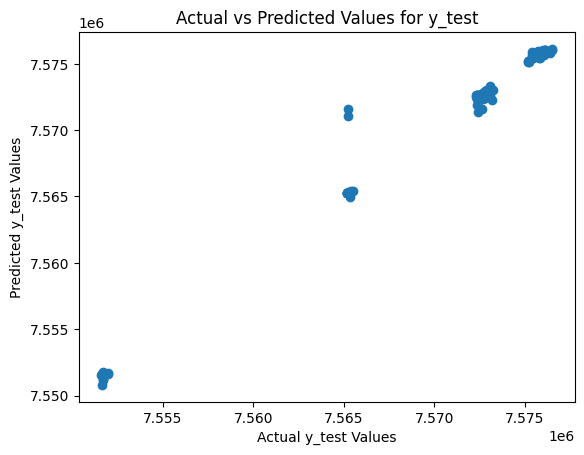

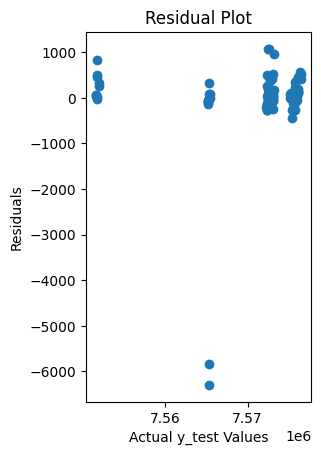

In [69]:
####### these plots would be better at the point of the tower estimates

# Plot the estimated vs actual predictions
plt.scatter(y_true, y_pred)
plt.xlabel("Actual y_test Values")
plt.ylabel("Predicted y_test Values")
plt.title("Actual vs Predicted Values for y_test")
plt.show()

# Plot the residuals
residuals = y_true - y_pred
plt.subplot(1, 2, 2)
plt.scatter(y_true, residuals)
plt.xlabel("Actual y_test Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()